# Big Data Analytics and Modelling Assessment 1.
### The references for this code are cited here, at the top of the code cell, and referenced fully on the report's reference list uploaded with this document. Lecture material was also used. Basic descriptions of the code are included here, with critical analysis elements included in section III of the report. 

In [60]:
# The necessary libraries were imported.
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

### Dataset Loading and Pre-processing.

In [61]:
# A Spark session was initialised (Spark.R, 2024)
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# The data was loaded into the Spark dataframe and the first 10 rows displayed.
df = spark.read.csv('C:/Users/Computing/Downloads/BDAM Assessment/assessment.csv', header=True, inferSchema=True)
df.show(10)

# To understand the size of the dataset, the number of rows and columns were checked
# and the shape of the dataframe printed.
row_num = df.count()
col_num = len(df.columns)
print("Dataframe shape: ({}, {})".format(row_num, col_num))

# To check if the columns needed transforming, the datatype of each column is checked and printed. 
df.printSchema()

# Despite 'Decile' being a integer, it represents categories and was defined as a text (string value) by
# the original dataset, therefore the same will be done here. 
df = df.withColumn("Decile", df["Decile"].cast("string"))

# Missing values were checked for and removed to maintain data integrity and improve model performance. 
df =df.na.drop()

# Categorical columns were converted to numerical representations using StringIndexer. 
# This converted them to numerical indices and treated them as ordinal values.
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip")
    for col in ['Period', 'Decile', 'Gender', 'Agegroup']
]

# The OneHotEncoder was then used to convert numerical indices into binary vectors, 
# this ensured the model does not interpret numerical indices as ordinal, as when tested, this affected model performance. 
encoder = OneHotEncoder(
    inputCols=[col + "_index" for col in ['Period', 'Decile', 'Gender', 'Agegroup']],
    outputCols=[col + "_encoded" for col in ['Period', 'Decile', 'Gender', 'Agegroup']],
)
 
# The independent variables were assembled using the VectorAssembler. 
# This combined the columns into a single vector column, ensuring algorithm compatability, pipeline compatibility and
# model consistency.
assembler = VectorAssembler(
    inputCols=[col + "_encoded" for col in ['Period', 'Decile', 'Gender', 'Agegroup']],
    outputCol="features",
)

+---------+------+------+--------+---------------+
|   Period|Decile|Gender|Agegroup|Life_Expectancy|
+---------+------+------+--------+---------------+
|2011-2013|     1|  Male|<1      |          73.87|
|2011-2013|     1|  Male|     1-4|          73.38|
|2011-2013|     1|  Male|     5-9|          69.46|
|2011-2013|     1|  Male|   10-14|          64.49|
|2011-2013|     1|  Male|15-19   |          59.54|
|2011-2013|     1|  Male|20-24   |          54.66|
|2011-2013|     1|  Male|25-29   |          49.83|
|2011-2013|     1|  Male|30-34   |          45.06|
|2011-2013|     1|  Male|35-39   |          40.35|
|2011-2013|     1|  Male|40-44   |          35.78|
+---------+------+------+--------+---------------+
only showing top 10 rows

Dataframe shape: (2800, 5)
root
 |-- Period: string (nullable = true)
 |-- Decile: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Agegroup: string (nullable = true)
 |-- Life_Expectancy: double (nullable = true)



### Linear Regression and Pipeline.

In [62]:
# The Linear Regression model was initiated to define the type of model to be trained (Spark.R 2024)
lr = LinearRegression(featuresCol="features", labelCol="Life_Expectancy")

# A single pipeline was created to ensure the steps are executed consistently and 
# can be reproduced. 
pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# The data was split into training (70%) and test (30%) sets, so the model could be evaluated
# on unseen data and it's generalisation ability tested. 
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=1234)

# The pipeline was fit to the training data only to prevent data leakage. 
model = pipeline.fit(train_data)

# Predictions on both train and test sets were made to asses how well the model
# fits the training data and its performance on unseen data. 
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

### Model Evaluation Metrics.

In [63]:
# The model on both train and test sets was evaluated using the required metrics.
# Each metric provides a different perspective on the model's error and accuracy (Spark.R 2024) 
evaluator = RegressionEvaluator(labelCol="Life_Expectancy", predictionCol="prediction", metricName="mae")
mae_train = evaluator.evaluate(train_predictions)
mae_test = evaluator.evaluate(test_predictions)

evaluator = RegressionEvaluator(labelCol="Life_Expectancy", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
rmse_test = evaluator.evaluate(test_predictions)

evaluator = RegressionEvaluator(labelCol="Life_Expectancy", predictionCol="prediction", metricName="mse")
mse_train = evaluator.evaluate(train_predictions)
mse_test = evaluator.evaluate(test_predictions)

# The evaluation metrics for both train and test sets were printed for simple comparisons.
# This enables identification of model overfitting or underfitting. 
print("Train Set Metrics:")
print(f"MAE: {mae_train}")
print(f"RMSE: {rmse_train}")
print(f"MSE: {mse_train}")

print("\nTest Set Metrics:")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MSE: {mse_test}")

Train Set Metrics:
MAE: 0.5923443936162667
RMSE: 0.8709116586321258
MSE: 0.7584871171413604

Test Set Metrics:
MAE: 0.6381160273897168
RMSE: 0.9782384298185735
MSE: 0.956950425573908


### Results.


Predicted vs Actual Values (Test Set)
     Actual  Prediction
696   64.25   64.749001
667   66.50   66.324057
63    77.90   78.552287
533   59.15   58.837828
66     8.16    6.947278
..      ...         ...
199   74.50   73.982390
365   10.90   12.988180
486   20.92   21.099507
594   44.31   43.663771
568   60.53   60.012673

[80 rows x 2 columns]


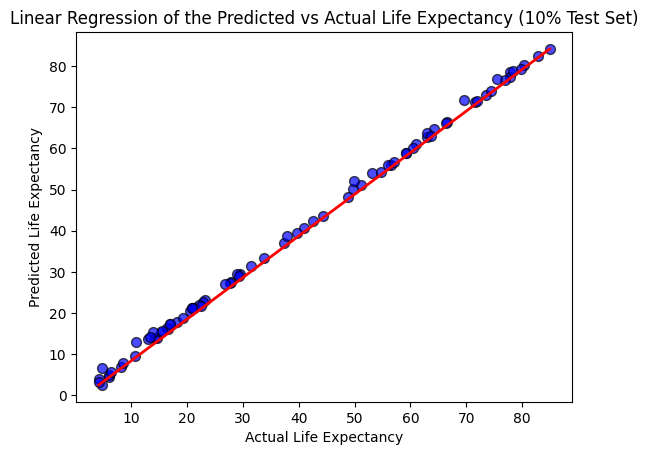

In [64]:
# A 10% sample of the predicted vs actual values for the test set was printed (Spark.R, 2024).
# As there are many values for the test set, displaying a small sample of this made the results easier to interpret. 
sample_test_predictions = test_predictions.select(test_predictions["Life_Expectancy"].alias("Actual"), test_predictions["prediction"].alias("Prediction")).toPandas().sample(frac=0.1, random_state=42)
print("\nPredicted vs Actual Values (Test Set)")
print(sample_test_predictions)

# The predicted vs actual scatter plot for the sample test set with a red line for linear regression fit. 
plt.scatter(
    sample_test_predictions["Actual"], 
    sample_test_predictions["Prediction"], 
    s=50, 
    alpha=0.7, 
    color="blue",  
    edgecolor="black", 
)  
plt.plot(
    [min(sample_test_predictions["Actual"]), max(sample_test_predictions["Actual"])],
    [min(sample_test_predictions["Prediction"]), max(sample_test_predictions["Prediction"])],
    color='red', linewidth=2
)
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Linear Regression of the Predicted vs Actual Life Expectancy (10% Test Set)")
plt.show()